In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalMaxPool1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras import backend as K

sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [131]:
filename = 'Filter_Toxic_Comments_dataset.csv'
df = pd.read_csv(filename)

print("Dataset Shape:")
display(df.shape)
print("First 5 Rows:")
display(df.head())

Dataset Shape:


(159571, 8)

First 5 Rows:


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [132]:
print("Dataset info:")
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB
None


#### Label Distribution Analysis

Labels Frequency Table:


,Absolute Frequency,Relative Frequency (%)
sum_injurious,35098,22.00
toxic,15294,9.58
obscene,8449,5.29
insult,7877,4.94
severe_toxic,1595,1.00
identity_hate,1405,0.88
threat,478,0.30


----------------------------------------------------------------------
Total Comments in the Dataset: 159571
Clean Comments: 143346 (89.83%)
Comments with at least one toxicity: 16225 (10.17%)


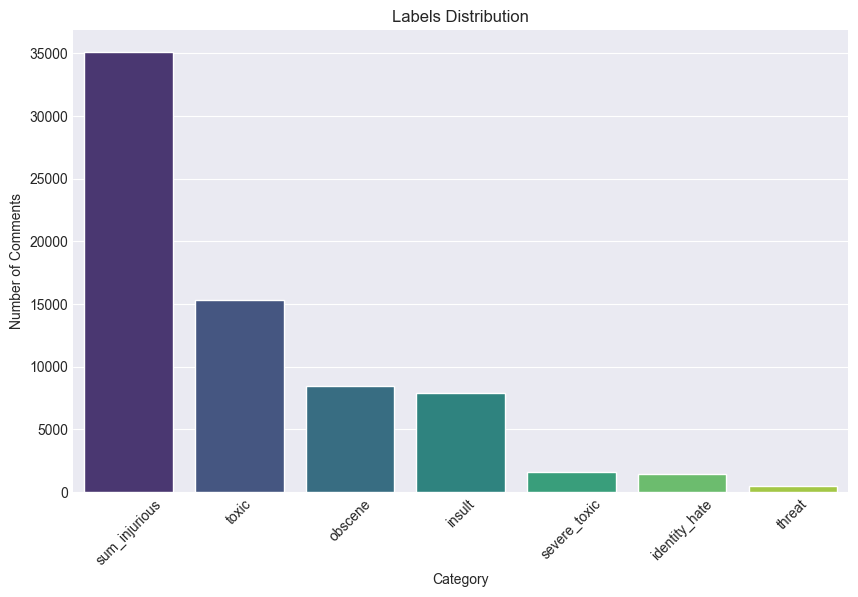

In [133]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_injurious']

absolute_freq = df[target_columns].sum()
relative_freq = (absolute_freq/ len(df)) * 100

stats_df = pd.DataFrame({
    'Absolute Frequency': absolute_freq,
    'Relative Frequency (%)': relative_freq
})

stats_df = stats_df.sort_values(by='Absolute Frequency', ascending=False)
stats_df['Relative Frequency (%)'] = stats_df['Relative Frequency (%)'].round(2)

print("Labels Frequency Table:")
display(stats_df)

print("-" * 70)

clean_comments_count = df[df[target_columns].sum(axis=1) == 0].shape[0]
total_comments = len(df)
clean_perc = (clean_comments_count/total_comments)*100

print(f"Total Comments in the Dataset: {total_comments}")
print(f"Clean Comments: {clean_comments_count} ({clean_perc:.2f}%)")
print(f"Comments with at least one toxicity: {total_comments-clean_comments_count} ({100-clean_perc:.2f}%)")

plt.figure(figsize=(10,6))
sns.barplot(x=stats_df.index, y=stats_df['Absolute Frequency'], palette = 'viridis')
plt.title('Labels Distribution')
plt.ylabel('Number of Comments')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()

The dataset exhibits a **severe class imbalance**:
* **Majority Class:** Nearly **90%** of the comments are "clean" (non-toxic).
* **Minority Classes:** Toxic categories are rare, with `threat` and `identity_hate` appearing in less than **1%** of the dataset (0.30% and 0.88%, respectively).

**Implication:** A standard model might achieve high accuracy simply by predicting "clean" for every input, but it would fail to detect the most critical toxic behaviors. We will need to address this using techniques like **Oversampling** or **Weighted Loss Functions** later in the pipeline.

#### Text Cleaning

In [134]:
def clean_text(text):

    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [135]:
df['clean_text'] = df['comment_text'].apply(clean_text)

In [136]:
display(df.head())
print('\nComparison between Original & Clean (first 3 Toxic examples):')
toxic_samples = df[df['toxic'] == 1].sample(3)
for index, row in toxic_samples.iterrows():
    print(f"\nOriginal: {row['comment_text'][:100]}...")
    print(f"Clean: {row['clean_text'][:100]}...")

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,clean_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir are my hero any chance you remember wh...



Comparison between Original & Clean (first 3 Toxic examples):

Original: hell 

my suspicion was true - wikipedia is driven by atheists to hell......
Clean: hell my suspicion was true wikipedia is driven by atheists to hell...

Original: TAB
Don't be a Dick
You know what you did, don't do it again. You weren't making test edit or anythi...
Clean: tab dont be a dick you know what you did dont do it again you werent making test edit or anything ev...

Original: Ho ho, you fucking twats really do make me laugh. 46.37.55.80...
Clean: ho ho you fucking twats really do make me laugh...


We applied a targeted cleaning function to normalize the input text while preserving semantic meaning crucial for toxicity detection.

**Key Steps:**
1.  **Noise Removal:** Stripped technical noise like IP addresses, URLs, and non-alphabetic characters (e.g., numbers, excessive punctuation) to reduce vocabulary sparsity.
2.  **Normalization:** Converted all text to lowercase to treat "Stupid" and "stupid" as the same token.

**Strategic Decisions (What we did NOT do):**
* **No Stop Word Removal:** We retained stop words (e.g., "you", "not", "is") because they carry vital context in toxic comments. For example, *"I hate **you**"* (personal attack) vs *"I hate myself"* (self-deprecation) requires pronouns to be distinguished.
* **No Lemmatization/Stemming:** We avoided reducing words to their roots (e.g., keeping "killing" vs "kill") to preserve the specific tone and intensity of the language used in online harassment.

#### Statistic Text Analysis

Descriptive Statistics (Word Length)
count    159571.000000
mean         65.411867
std          97.295380
min           0.000000
25%          16.000000
50%          35.000000
75%          73.000000
max        1403.000000
Name: word_count, dtype: float64

--- Percentile Analysis (Coverage) ---
90% of comments have fewer than 149 words.
95% of comments have fewer than 223 words.
98% of comments have fewer than 377 words.
99% of comments have fewer than 555 words.


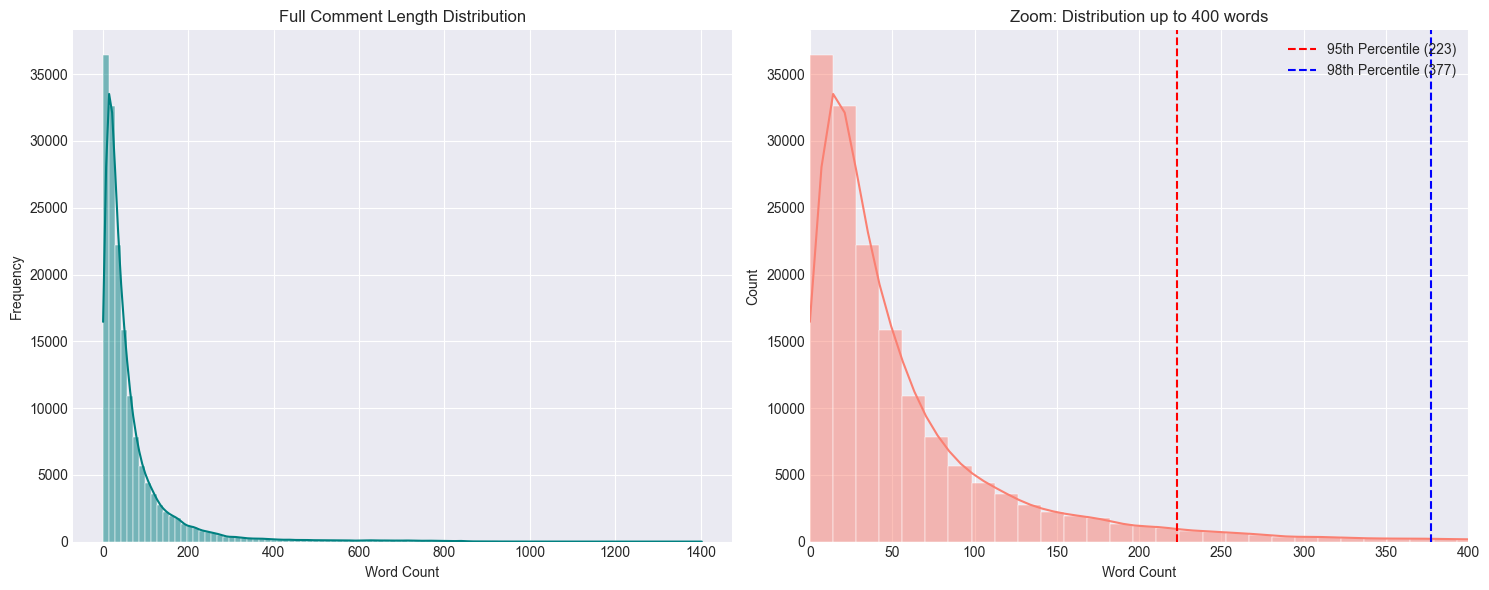

In [137]:
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

print("Descriptive Statistics (Word Length)")
print(df['word_count'].describe())

p90 = np.percentile(df['word_count'], 90)
p95 = np.percentile(df['word_count'], 95)
p98 = np.percentile(df['word_count'], 98)
p99 = np.percentile(df['word_count'], 99)

print("\n--- Percentile Analysis (Coverage) ---")
print(f"90% of comments have fewer than {int(p90)} words.")
print(f"95% of comments have fewer than {int(p95)} words.")
print(f"98% of comments have fewer than {int(p98)} words.")
print(f"99% of comments have fewer than {int(p99)} words.")

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=100, color='teal', kde=True)
plt.title('Full Comment Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=100, color='salmon', kde=True)
plt.title('Zoom: Distribution up to 400 words')
plt.xlabel('Word Count')
plt.xlim(0, 400)

plt.axvline(p95, color='red', linestyle='--', label=f'95th Percentile ({int(p95)})')
plt.axvline(p98, color='blue', linestyle='--', label=f'98th Percentile ({int(p98)})')
plt.legend()

plt.tight_layout()
plt.show()

Total Unique Words (Vocabulary): 217096
Total Words in Corpus: 10437837
----------------------------------------
Coverage using Top 20,000 words: 95.88%
Words needed for 95% coverage: 14955
Words needed for 98% coverage: 54468
----------------------------------------


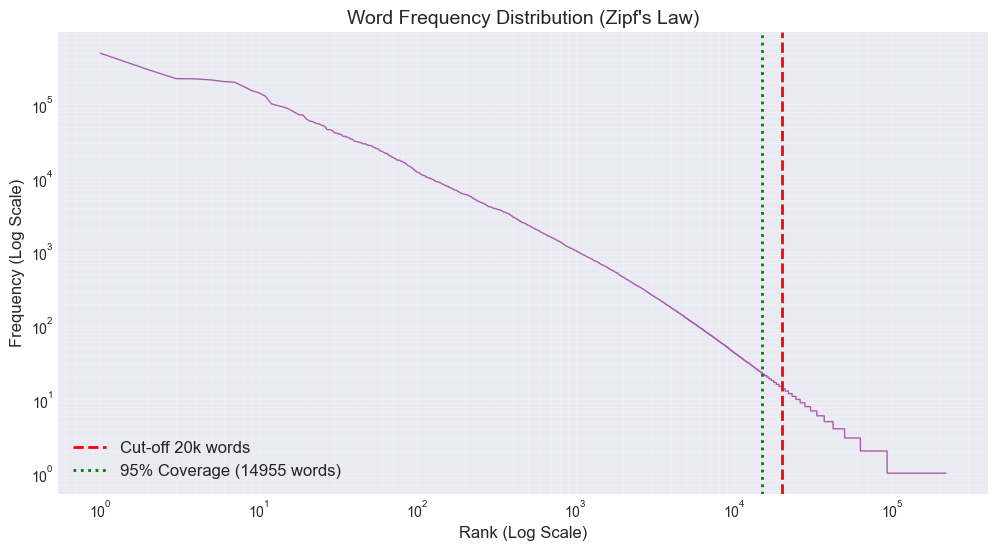

In [138]:
all_words = []
for text in df['clean_text']:
    all_words.extend(str(text).split())

words_count = Counter(all_words)
freq_df = pd.DataFrame(words_count.most_common(), columns = ['word', 'count'])
total_words = freq_df['count'].sum()
freq_df['cumulative_count'] = freq_df['count'].cumsum()
freq_df['coverage_percent'] = (freq_df['cumulative_count'] / total_words) * 100

total_unique_words = len(freq_df)

if total_unique_words >= 20000:
    coverage_20k = freq_df.iloc[19999]['coverage_percent']
else:
    coverage_20k = 100.0

words_for_95 = freq_df[freq_df['coverage_percent'] >= 95].index[0] + 1
words_for_98 = freq_df[freq_df['coverage_percent'] >= 98].index[0] + 1

print(f"Total Unique Words (Vocabulary): {total_unique_words}")
print(f"Total Words in Corpus: {total_words}")
print("-" * 40)
print(f"Coverage using Top 20,000 words: {coverage_20k:.2f}%")
print(f"Words needed for 95% coverage: {words_for_95}")
print(f"Words needed for 98% coverage: {words_for_98}")
print("-" * 40)

plt.figure(figsize=(12, 6))
plt.loglog(range(1, len(freq_df) + 1), freq_df['count'], color='purple', alpha=0.6, linewidth=1)

plt.title("Word Frequency Distribution (Zipf's Law)", fontsize=14)
plt.xlabel("Rank (Log Scale)", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)

plt.axvline(x=20000, color='red', linestyle='--', linewidth=2, label='Cut-off 20k words')
plt.axvline(x=words_for_95, color='green', linestyle=':', linewidth=2, label=f'95% Coverage ({words_for_95} words)')

plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

We performed a statistical analysis of the text distribution to determine optimal hyperparameters for the neural network inputs.

**1. Sequence Length (`MAX_LEN` = 225)**
* The analysis reveals a skewed distribution: while the longest comment has 1,403 words, **95% of comments contain fewer than 223 words**.
* **Decision:** We set `MAX_LEN = 225`. This threshold ensures that we capture the complete text for over 95% of the samples without excessive padding (zeros) that would waste computational resources.

**2. Vocabulary Size (`MAX_FEATURES` = 20,000)**
* The total corpus contains over **217,000 unique words**, but the majority are rare (e.g., typos, unique names).
* Our coverage analysis shows that the **top 20,000 words account for 95.88%** of all text occurrences.
* **Decision:** We limited the vocabulary to the top **20,000 words**. This drastically reduces model dimensionality and noise while retaining nearly all relevant semantic information.

#### Tokenization & Padding

In [139]:
MAX_FEATURES = 20000
MAX_LEN = 225
EMBEDDING_DIM = 100
OOV_TOKEN = '<OOV>'

In [140]:
X = df['clean_text'].values
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state = 42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 0.5, random_state = 42
)

print("\nVector Dimension Check:")
print(f"Training Set (Text):   {X_train.shape} | Target: {y_train.shape} -> (80%)")
print(f"Validation Set (Text): {X_val.shape}  | Target: {y_val.shape}  -> (10%)")
print(f"Test Set (Text):       {X_test.shape}  | Target: {y_test.shape}  -> (10%)")


Vector Dimension Check:
Training Set (Text):   (127656,) | Target: (127656, 6) -> (80%)
Validation Set (Text): (15957,)  | Target: (15957, 6)  -> (10%)
Test Set (Text):       (15958,)  | Target: (15958, 6)  -> (10%)


In [141]:
tokenizer = Tokenizer(num_words = MAX_FEATURES, oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(f"Vocabulary Created. Total Unique Words: {len(word_index)}")
print(f"Words Kept: Top {MAX_FEATURES}")

Vocabulary Created. Total Unique Words: 187980
Words Kept: Top 20000


In [142]:
def process_text(text_data, set_name):
    seqs = tokenizer.texts_to_sequences(text_data)
    padded = pad_sequences(seqs, maxlen = MAX_LEN, padding = 'pre', truncating='post')
    print(f"{set_name} processed. Shape: {padded.shape}")
    return padded

In [143]:
X_train = process_text(X_train, "Training Set")
X_val = process_text(X_val, "Validation Set")
X_test = process_text(X_test, "Test Set")

print("\n--- FINAL INPUT SHAPES (Ready for Model) ---")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")

Training Set processed. Shape: (127656, 225)
Validation Set processed. Shape: (15957, 225)
Test Set processed. Shape: (15958, 225)

--- FINAL INPUT SHAPES (Ready for Model) ---
X_train: (127656, 225)
X_val:   (15957, 225)
X_test:  (15958, 225)


In [144]:
print("\nSample processed sequence (X_train[0]):")
print(X_train[0])


Sample processed sequence (X_train[0]):
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0    

In this step, we transformed raw text into a numerical format suitable for the Neural Network.

**1. Train/Val/Test Split:**
We partitioned the dataset into three subsets to prevent overfitting and ensure unbiased evaluation:
* **Training (80%):** Used to learn the model weights.
* **Validation (10%):** Used to tune hyperparameters and monitor loss during training.
* **Test (10%):** Used **only** for the final performance assessment.

**2. Tokenization:**
* We fitted the `Tokenizer` **strictly on the Training set** to avoid data leakage (the model should not "know" words that appear only in the test set).
* The top **20,000** most frequent words were assigned unique integer indices.
* **Special Tokens:** Index `1` is reserved for **OOV** (Out-Of-Vocabulary) words, while Index `0` is reserved for padding.

**3. Sequence Padding:**
* All sequences were standardized to a fixed length of **225 integers**.
* We used **`padding='pre'`** (adding zeros at the beginning). This is often preferred for Recurrent Neural Networks (RNNs/LSTMs) because it keeps the meaningful content at the end of the sequence, closer to the final output generation.

#### Model Setting & Evaluation

We designed a Recurrent Neural Network (RNN) specifically optimized for text classification tasks.

* **Embedding Layer:** Maps each word index to a 100-dimensional dense vector, capturing semantic relationships between words.
* **Bidirectional LSTM:** The core of the model. Unlike a standard LSTM that reads text only from left to right, the **Bidirectional** wrapper processes the sequence in both directions (Past ↔ Future). This allows the model to understand the full context of a sentence (e.g., sarcasm or negation at the end of a phrase).
* **GlobalMaxPool1D:** Extracts the most significant feature (the "strongest" signal of toxicity) from the entire time sequence, reducing dimensionality and preventing overfitting.
* **Dense + Dropout:** A fully connected layer with ReLU activation to combine features, followed by Dropout (0.1) to regularize the model.
* **Output Layer:** 6 neurons with **Sigmoid** activation, one for each class. This allows independent binary classification for each label (Multi-Label setting).

1. Evaluation without manage class imbalance

In [145]:
LSTM_UNITS = 64

model = Sequential()
model.add(Embedding(
    input_dim = MAX_FEATURES,
    output_dim = EMBEDDING_DIM,
    input_length = MAX_LEN
))
model.add(Bidirectional(LSTM(
    LSTM_UNITS,
    return_sequences = True,
    name = 'lstm_layer'
)))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(
    6,
    activation = "sigmoid"
))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 225, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 225, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,091,236 (7.98 MB)

 Trainable params: 2,091,236 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
BATCH_SIZE = 64
EPOCHS = 5

callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 1, verbose = 1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8152 - loss: 0.1042
Epoch 1: val_loss improved from None to 0.05022, saving model to best_model.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 443s 221ms/step - accuracy: 0.9278 - loss: 0.0661 - val_accuracy: 0.9930 - val_loss: 0.0502
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9859 - loss: 0.0452
Epoch 2: val_loss improved from 0.05022 to 0.04757, saving model to best_model.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 454s 228ms/step - accuracy: 0.9838 - loss: 0.0451 - val_accuracy: 0.9930 - val_loss: 0.0476
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9641 - loss: 0.0401
Epoch 3: val_loss did not improve from 0.04757
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 548s 274ms/step - accuracy: 0.9632 - loss: 0.0398 - val_accuracy: 0.9930 - val_loss: 0.0488
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.


In [147]:
print("EVALUATING ON UNSEEN TEST SET")

test_results = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose=1)

print(f"\n Test Set Loss: {test_results[0]:.4f}")
print(f"Test Set Accuracy: {test_results[1]*100:.2f}%")

EVALUATING ON UNSEEN TEST SET
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9952 - loss: 0.0453

 Test Set Loss: 0.0453
Test Set Accuracy: 99.52%


Generating Learning Curves...


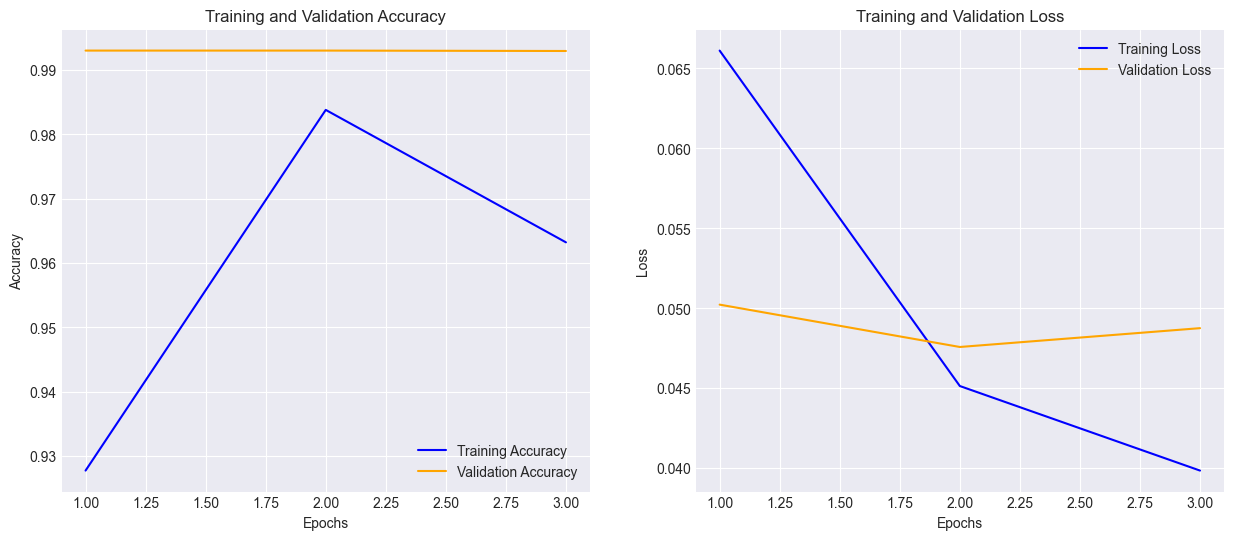


Generating Detailed Classification Report...
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step

--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        toxic       0.85      0.75      0.80      1520
 severe_toxic       0.73      0.05      0.09       162
      obscene       0.84      0.78      0.81       856
       threat       0.00      0.00      0.00        37
       insult       0.75      0.70      0.73       808
identity_hate       0.00      0.00      0.00       138

    micro avg       0.82      0.68      0.74      3521
    macro avg       0.53      0.38      0.40      3521
 weighted avg       0.78      0.68      0.71      3521
  samples avg       0.07      0.06      0.06      3521


Weighted ROC-AUC Score: 0.9833


In [148]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

print("Generating Learning Curves...")
plot_history(history)

print("\nGenerating Detailed Classification Report...")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

auc_score = roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class='ovr')
print(f"\nWeighted ROC-AUC Score: {auc_score:.4f}")

The initial training with standard **Binary Crossentropy** (without handling class imbalance) highlights a critical issue:

* **High Performance on Frequent Classes:** Labels like `toxic` and `obscene` show good F1-scores (~0.80), as the model has sufficient examples to learn patterns.
* **Failure on Rare Classes:**
    * **Threat:** F1-Score = **0.00**
    * **Identity Hate:** F1-Score = **0.00**
    * **Severe Toxic:** F1-Score = **0.09**

**Diagnosis:** The model has learned to ignore the minority classes. Since they appear so rarely (<1% of data), the model minimizes the global loss by simply predicting "0" (Clean) for them. While this yields high accuracy (99%), it renders the model **useless for safety purposes**, as it completely misses the most dangerous content.

**Next Step:** We must address this imbalance using **Weighted Loss** or **Oversampling**.

2. Evaluation with custom loss function

In [149]:
counts = np.sum(y_train, axis = 0)
total_samples = y_train.shape[0]

class_weights_array = (total_samples/counts) / 2.0

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, label in enumerate(labels):
    print(f"{label}: {counts[i]} samples -> Class Weight: {class_weights_array[i]:.2f}")

toxic: 12238 samples -> Class Weight: 5.22
severe_toxic: 1274 samples -> Class Weight: 50.10
obscene: 6734 samples -> Class Weight: 9.48
threat: 404 samples -> Class Weight: 157.99
insult: 6263 samples -> Class Weight: 10.19
identity_hate: 1111 samples -> Class Weight: 57.45


In [150]:
def get_weighted_loss(weights):
    weights_tensor = tf.constant(weights, dtype=tf.float32)

    def weighted_binary_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)

        y_true_float = tf.cast(y_true, tf.float32)
        weight_vector = y_true_float * weights_tensor + (1.0 - y_true_float) * 1.0

        weighted_bce = bce * weight_vector

        return K.mean(weighted_bce)
    
    return weighted_binary_crossentropy

In [151]:
LSTM_UNITS = 64

model = Sequential()
model.add(Embedding(
    input_dim = MAX_FEATURES,
    output_dim = EMBEDDING_DIM,
    input_length = MAX_LEN
))
model.add(Bidirectional(LSTM(
    LSTM_UNITS,
    return_sequences = True,
    name = 'lstm_layer'
)))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(
    6,
    activation = "sigmoid"
))
model.compile(loss = get_weighted_loss(class_weights_array),
              optimizer = 'adam',
              metrics = ['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 225, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 225, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,091,236 (7.98 MB)

 Trainable params: 2,091,236 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
BATCH_SIZE = 64
EPOCHS = 5

callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 1, verbose = 1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5089 - loss: 0.4957
Epoch 1: val_loss improved from None to 0.27149, saving model to best_model.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 351s 175ms/step - accuracy: 0.6487 - loss: 0.3619 - val_accuracy: 0.6100 - val_loss: 0.2715
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9441 - loss: 0.2302
Epoch 2: val_loss improved from 0.27149 to 0.25941, saving model to best_model.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 366s 183ms/step - accuracy: 0.9617 - loss: 0.2299 - val_accuracy: 0.9930 - val_loss: 0.2594
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9886 - loss: 0.1838
Epoch 3: val_loss improved from 0.25941 to 0.25603, saving model to best_model.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 380s 191ms/step - accuracy: 0.9816 - loss: 0.1827 - val_accuracy: 0.9917 - val_loss: 0.2560
Epoch 4/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9824 - loss: 0.1489
Epoch 4: val_loss did n

In [153]:
print("EVALUATING ON UNSEEN TEST SET")

test_results = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose=1)

print(f"\n Test Set Loss: {test_results[0]:.4f}")
print(f"Test Set Accuracy: {test_results[1]*100:.2f}%")

EVALUATING ON UNSEEN TEST SET
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9931 - loss: 0.2433

 Test Set Loss: 0.2433
Test Set Accuracy: 99.31%


Generating Learning Curves...


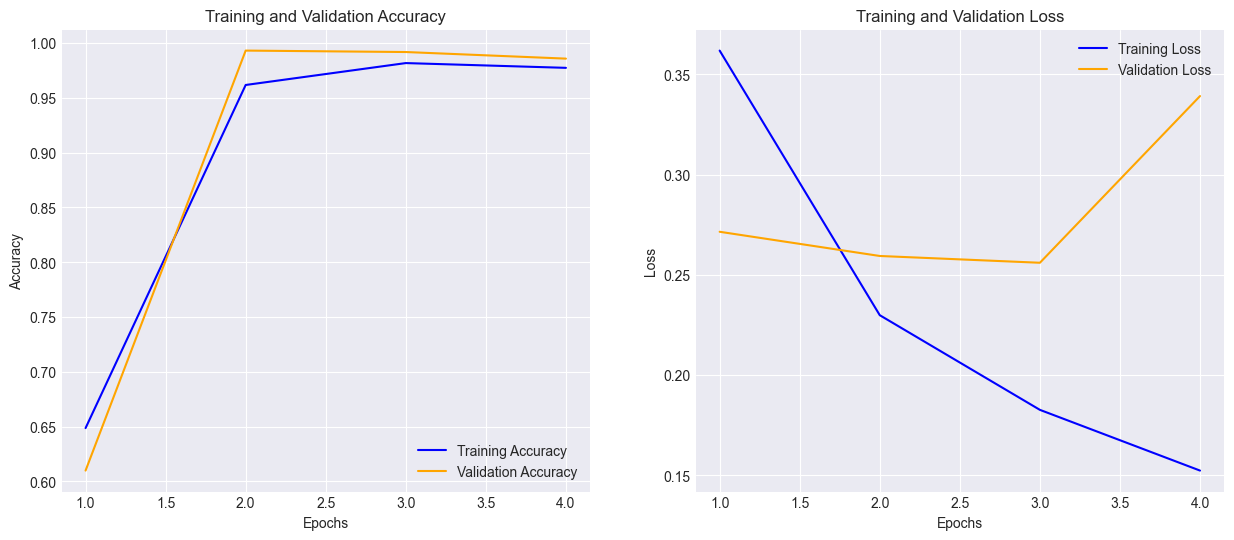


Generating Detailed Classification Report...
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step

--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        toxic       0.61      0.89      0.72      1520
 severe_toxic       0.20      0.94      0.32       162
      obscene       0.58      0.94      0.72       856
       threat       0.06      0.95      0.12        37
       insult       0.48      0.93      0.64       808
identity_hate       0.10      0.84      0.18       138

    micro avg       0.42      0.91      0.58      3521
    macro avg       0.34      0.91      0.45      3521
 weighted avg       0.53      0.91      0.66      3521
  samples avg       0.05      0.09      0.06      3521


Weighted ROC-AUC Score: 0.9794


In [154]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

print("Generating Learning Curves...")
plot_history(history)

print("\nGenerating Detailed Classification Report...")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

auc_score = roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class='ovr')
print(f"\nWeighted ROC-AUC Score: {auc_score:.4f}")

To address the zero-recall issue on rare classes, we introduced a **Custom Weighted Loss Function**. Weights were calculated inversely proportional to class frequency (e.g., `threat` received a weight of ~158x).

**Results:**
* **Recall Explosion:** The model now successfully detects almost all toxic comments. Recall for `threat` jumped from **0.00** to **0.95**, and for `identity_hate` from **0.00** to **0.84**.
* **Precision Collapse:** The massive penalty for missing a threat made the model overly aggressive ("paranoid"). Precision for `threat` dropped to **0.06**, meaning for every 1 true threat detected, the model flags ~16 false positives.

**Conclusion:** While this approach solves the "invisibility" of rare classes, the extreme weights cause too many false alarms, rendering the F1-Score suboptimal (0.12 for `threat`). We need a more balanced approach.

3. Evaluation with Smooth Custom Loss Function

In [155]:
counts = np.sum(y_train, axis = 0)
total_samples = y_train.shape[0]

class_weights_array = (total_samples/counts) / 2.0
smooth_weights = np.log(class_weights_array) * 2.0

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, label in enumerate(labels):
    print(f"{label}: {counts[i]} samples -> Raw Weight: {class_weights_array[i]:.2f} -> Smooth Weight: {smooth_weights[i]:.2f}")

toxic: 12238 samples -> Raw Weight: 5.22 -> Smooth Weight: 3.30
severe_toxic: 1274 samples -> Raw Weight: 50.10 -> Smooth Weight: 7.83
obscene: 6734 samples -> Raw Weight: 9.48 -> Smooth Weight: 4.50
threat: 404 samples -> Raw Weight: 157.99 -> Smooth Weight: 10.13
insult: 6263 samples -> Raw Weight: 10.19 -> Smooth Weight: 4.64
identity_hate: 1111 samples -> Raw Weight: 57.45 -> Smooth Weight: 8.10


In [156]:
def get_weighted_loss(weights):
    weights_tensor = tf.constant(weights, dtype=tf.float32)

    def weighted_binary_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)

        y_true_float = tf.cast(y_true, tf.float32)
        weight_vector = y_true_float * weights_tensor + (1.0 - y_true_float) * 1.0

        weighted_bce = bce * weight_vector

        return K.mean(weighted_bce)
    
    return weighted_binary_crossentropy

In [157]:
LSTM_UNITS = 64

model = Sequential()
model.add(Embedding(
    input_dim = MAX_FEATURES,
    output_dim = EMBEDDING_DIM,
    input_length = MAX_LEN
))
model.add(Bidirectional(LSTM(
    LSTM_UNITS,
    return_sequences = True,
    name = 'lstm_layer'
)))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(
    6,
    activation = "sigmoid"
))
model.compile(loss = get_weighted_loss(smooth_weights),
              optimizer = 'adam',
              metrics = ['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 225, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 225, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,091,236 (7.98 MB)

 Trainable params: 2,091,236 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
BATCH_SIZE = 64
EPOCHS = 5

callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 1, verbose = 1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8089 - loss: 0.2407
Epoch 1: val_loss improved from None to 0.13009, saving model to best_model.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 478s 238ms/step - accuracy: 0.9063 - loss: 0.1689 - val_accuracy: 0.9930 - val_loss: 0.1301
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9861 - loss: 0.1156
Epoch 2: val_loss did not improve from 0.13009
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 448s 225ms/step - accuracy: 0.9855 - loss: 0.1165 - val_accuracy: 0.9930 - val_loss: 0.1305
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [159]:
print("EVALUATING ON UNSEEN TEST SET")

test_results = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose=1)

print(f"\n Test Set Loss: {test_results[0]:.4f}")
print(f"Test Set Accuracy: {test_results[1]*100:.2f}%")

EVALUATING ON UNSEEN TEST SET
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9952 - loss: 0.1229

 Test Set Loss: 0.1229
Test Set Accuracy: 99.52%


Generating Learning Curves...


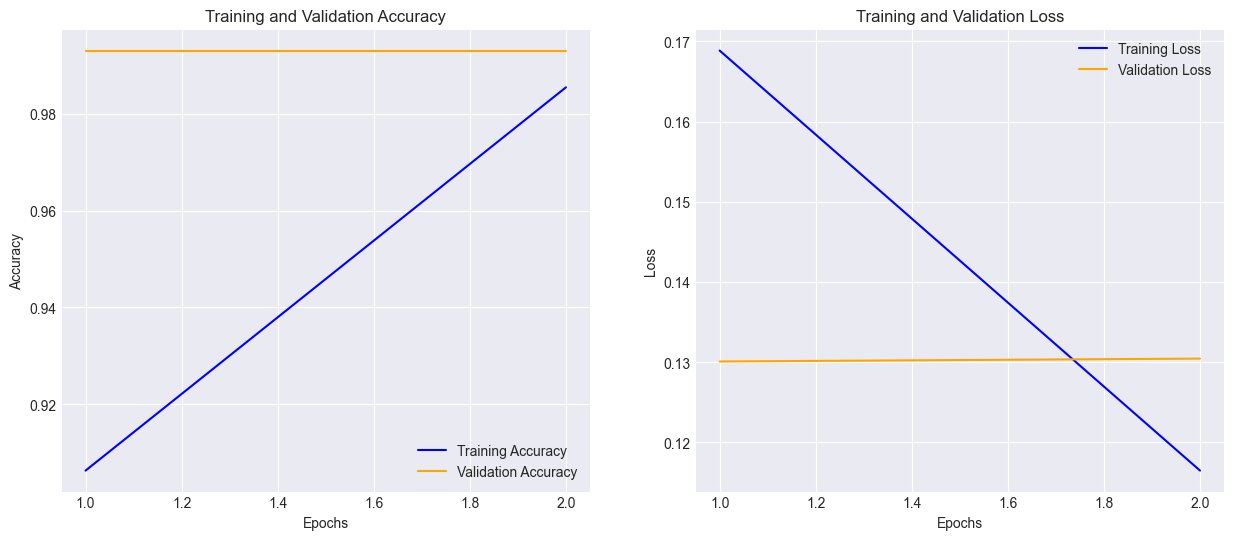


Generating Detailed Classification Report...
499/499 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step

--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        toxic       0.64      0.89      0.75      1520
 severe_toxic       0.31      0.85      0.46       162
      obscene       0.64      0.91      0.75       856
       threat       0.00      0.00      0.00        37
       insult       0.59      0.88      0.70       808
identity_hate       0.14      0.56      0.22       138

    micro avg       0.55      0.87      0.67      3521
    macro avg       0.39      0.68      0.48      3521
 weighted avg       0.59      0.87      0.70      3521
  samples avg       0.06      0.08      0.07      3521


Weighted ROC-AUC Score: 0.9820


In [160]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

print("Generating Learning Curves...")
plot_history(history)

print("\nGenerating Detailed Classification Report...")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

auc_score = roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class='ovr')
print(f"\nWeighted ROC-AUC Score: {auc_score:.4f}")

We attempted to mitigate the "precision collapse" by applying a logarithmic scaling to the class weights. The goal was to dampen the extreme penalties for rare classes (e.g., reducing `threat` weight from ~158 to a smaller log-scaled value).

**Results:**
* **Improved Balance on Medium Classes:** Precision for classes like `severe_toxic` (0.31) and `identity_hate` (0.14) improved compared to the raw weights approach, showing a healthier trade-off.
* **Failure on the Rarest Class (`threat`):** Unfortunately, the smoothing reduced the penalty for the `threat` class too much. The model reverted to ignoring it completely (Recall: **0.00**, F1-Score: **0.00**).

**Conclusion:** Manipulating the Loss Function involves a delicate and unstable trade-off. "Softening" the weights fixes the precision but kills the recall for the rarest samples. We need a structural solution to the data scarcity problem itself.

4. Oversampling on Minority Classes

In [161]:
from sklearn.utils import shuffle

augment_strategies = [
    {'label_index': 3, 'class_name': 'threat', 'multiplier': 50},
    {'label_index': 5, 'class_name': 'identity_hate', 'multiplier': 15},
    {'label_index': 1, 'class_name': 'severe_toxic', 'multiplier': 10}
]

print(f"Original X_train shape: {X_train.shape}")
print(f"Original y_train shape: {y_train.shape}")

X_train_augmented = X_train.copy()
y_train_augmented = y_train.copy()

for strategy in augment_strategies:
    idx = strategy['label_index']
    mult = strategy['multiplier']
    name = strategy['class_name']
    
    target_indices = np.where(y_train[:, idx] == 1)[0]
    
    print(f"Augmenting '{name}': {len(target_indices)} samples * {mult}...")
    
    X_subset = X_train[target_indices]
    y_subset = y_train[target_indices]
    
    X_repeated = np.repeat(X_subset, mult, axis=0)
    y_repeated = np.repeat(y_subset, mult, axis=0)
    
    X_train_augmented = np.concatenate([X_train_augmented, X_repeated], axis=0)
    y_train_augmented = np.concatenate([y_train_augmented, y_repeated], axis=0)

X_train_final, y_train_final = shuffle(X_train_augmented, y_train_augmented, random_state=42)

print(f"\nFinal X_train shape: {X_train_final.shape}")
print(f"Final y_train shape: {y_train_final.shape}")

print("\nNew Class Counts in Training:")
new_counts = np.sum(y_train_final, axis=0)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, label in enumerate(labels):
    print(f"{label}: {new_counts[i]}")

Original X_train shape: (127656, 225)
Original y_train shape: (127656, 6)
Augmenting 'threat': 404 samples * 50...
Augmenting 'identity_hate': 1111 samples * 15...
Augmenting 'severe_toxic': 1274 samples * 10...

Final X_train shape: (177261, 225)
Final y_train shape: (177261, 6)

New Class Counts in Training:
toxic: 59273
severe_toxic: 22964
obscene: 43894
threat: 22934
insult: 44188
identity_hate: 24576


In [162]:
LSTM_UNITS = 64

model = Sequential()
model.add(Embedding(
    input_dim = MAX_FEATURES,
    output_dim = EMBEDDING_DIM,
    input_length = MAX_LEN
))
model.add(Bidirectional(LSTM(
    LSTM_UNITS,
    return_sequences = True,
    name = 'lstm_layer'
)))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(
    6,
    activation = "sigmoid"
))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 225, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 225, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_11         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,091,236 (7.98 MB)

 Trainable params: 2,091,236 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
BATCH_SIZE = 64
EPOCHS = 5

callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train_final, y_train_final,
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/5
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8900 - loss: 0.0540
Epoch 1: val_loss improved from None to 0.06060, saving model to best_model.keras
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 558s 202ms/step - accuracy: 0.8763 - loss: 0.0498 - val_accuracy: 0.9798 - val_loss: 0.0606
Epoch 2/5
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8439 - loss: 0.0345
Epoch 2: val_loss did not improve from 0.06060
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 602s 217ms/step - accuracy: 0.8497 - loss: 0.0340 - val_accuracy: 0.9641 - val_loss: 0.0656
Epoch 3/5
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8408 - loss: 0.0259
Epoch 3: val_loss did not improve from 0.06060
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 596s 215ms/step - accuracy: 0.8271 - loss: 0.0263 - val_accuracy: 0.9776 - val_loss: 0.0754
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [164]:
print("EVALUATING ON UNSEEN TEST SET")

test_results = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose=1)

print(f"\n Test Set Loss: {test_results[0]:.4f}")
print(f"Test Set Accuracy: {test_results[1]*100:.2f}%")

EVALUATING ON UNSEEN TEST SET
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9863 - loss: 0.0539

 Test Set Loss: 0.0539
Test Set Accuracy: 98.63%


Generating Learning Curves...


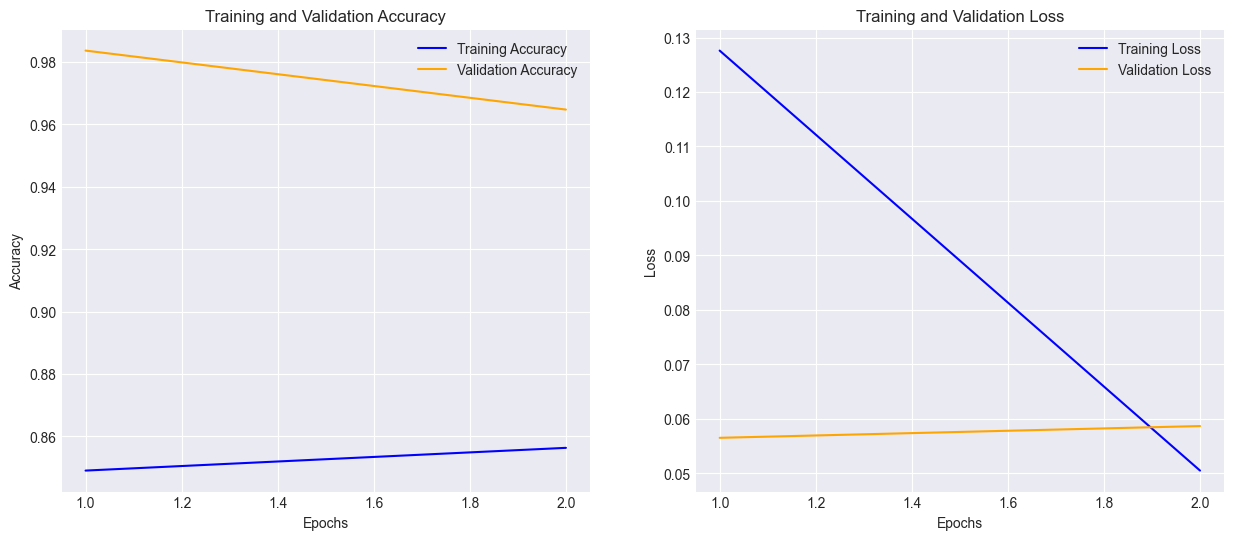


Generating Detailed Classification Report...
499/499 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step

--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        toxic       0.87      0.68      0.76      1520
 severe_toxic       0.36      0.62      0.46       162
      obscene       0.85      0.71      0.78       856
       threat       0.46      0.51      0.49        37
       insult       0.75      0.66      0.70       808
identity_hate       0.37      0.57      0.45       138

    micro avg       0.75      0.67      0.71      3521
    macro avg       0.61      0.62      0.61      3521
 weighted avg       0.79      0.67      0.72      3521
  samples avg       0.06      0.06      0.05      3521


Weighted ROC-AUC Score: 0.9782


In [165]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

print("Generating Learning Curves...")
plot_history(history)

print("\nGenerating Detailed Classification Report...")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

auc_score = roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class='ovr')
print(f"\nWeighted ROC-AUC Score: {auc_score:.4f}")

After manually augmenting the minority classes (`threat` x50, `identity_hate` x15) in the Training set, we achieved the most robust performance across all categories.

**Key Achievements:**
* **Unlocking the Rare Classes:** This is the only strategy that produced a viable F1-Score for `threat` (**0.49**) and `identity_hate` (**0.45**).
* **Balanced Trade-off:** Unlike the Weighted Loss approach (which had 0.95 Recall but ~0.06 Precision), Oversampling yielded a healthy balance:
    * **Threat:** Precision **0.46** / Recall **0.51**
    * **Identity Hate:** Precision **0.37** / Recall **0.57**
* **Global Stability:** The performance on frequent classes (`toxic`, `obscene`) remained high (~0.76 - 0.78), proving that augmenting rare data did not degrade the model's overall capability.

**Conclusion:** This experiment confirms that for extreme class imbalance in Deep Learning, providing the model with **more examples** (even if duplicated) is often superior to simply increasing the penalty for errors.